In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('ggplot')
pd.options.display.max_columns=100

In [2]:
df=pd.read_csv(r"C:\Users\berid\python\csv_files\AirlineReviews.csv")

In [3]:
df.sample(2)

,Aircraft,AirlineName,CabinType,DateFlown,DatePub,EntertainmentRating,FoodRating,GroundServiceRating,OriginCountry,OverallScore,Recommended,Review,Route,SeatComfortRating,ServiceRating,Slug,Title,TravelType,TripVerified,ValueRating,WifiRating,unique_id
41886,NaN,Ethiopian Airlines,Business Class,January 2018,4th January 2018,0,0,1,SouthAfrica,1.0,no,London to Johannesburg via Addis Ababa. The en...,London to Johannesburg via Addis Ababa,1,1,ethiopian-airlines,lost two of our three bags,Business,Trip Verified,1,0,87c0b711-f7d5-4744-b5d9-bb25b44db89b
121332,NaN,WestJet Airlines,Economy Class,October 2016,4th October 2016,0,2,1,UnitedKingdom,1.0,no,"✅ , | My flight from London Gatwick to Toront...",LGW to YYZ,2,2,westjet,staff were not helpful at all,Solo Leisure,NaN,1,0,9d7707ea-c5b9-46b9-b8d6-63f5b0ca988e


In [4]:
df.isna().mean()*100

Aircraft               71.863582
AirlineName             0.000000
CabinType               2.331312
DateFlown              29.710710
DatePub                 0.000000
EntertainmentRating     0.000000
FoodRating              0.000000
GroundServiceRating     0.000000
OriginCountry           1.296203
OverallScore            3.345564
Recommended             0.000000
Review                  0.636515
Route                  29.840485
SeatComfortRating       0.000000
ServiceRating           0.000000
Slug                    0.000000
Title                   0.003090
TravelType             29.592522
TripVerified           54.031903
ValueRating             0.000000
WifiRating              0.000000
unique_id               0.000000
dtype: float64

In [5]:
df.nunique()

Aircraft                 3633
AirlineName               547
CabinType                   4
DateFlown                 111
DatePub                  5200
EntertainmentRating         6
FoodRating                  6
GroundServiceRating         6
OriginCountry             202
OverallScore               10
Recommended                 2
Review                 128425
Route                   51401
SeatComfortRating           6
ServiceRating               6
Slug                      548
Title                   70975
TravelType                  4
TripVerified                6
ValueRating                 6
WifiRating                  6
unique_id              129455
dtype: int64

In [6]:
df['DatePub']=pd.to_datetime(df['DatePub'])

In [7]:
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

from nltk.corpus import stopwords
stopwords=stopwords.words('english')

In [8]:
def comment_sentiment_scores(comment):
    comment_tokenized=nltk.word_tokenize(comment)
    comment_lower=[w.lower() for w in comment_tokenized]
    comment_lemmatized=[lemmatizer.lemmatize(w) for w in comment_lower]
    comment_filtered=[w for w in comment_lemmatized if w not in stopwords]
    final_comment=' '.join(comment_filtered)
    
    score=sia.polarity_scores(final_comment)
    return score

In [9]:
%%time

scores = []

for i,review in enumerate(df['Review']):
    if isinstance(review, str):
        scores.append(comment_sentiment_scores(review))
    else:
        scores.append(None)

    if (i + 1) % int(len(df['Review'])/100)==0:
        print(f"Progress: {i + 1}/{len(df['Review'])}")

Progress: 1294/129455
Progress: 2588/129455
Progress: 3882/129455
Progress: 5176/129455
Progress: 6470/129455
Progress: 7764/129455
Progress: 9058/129455
Progress: 10352/129455
Progress: 11646/129455
Progress: 12940/129455
Progress: 14234/129455
Progress: 15528/129455
Progress: 16822/129455
Progress: 18116/129455
Progress: 19410/129455
Progress: 20704/129455
Progress: 21998/129455
Progress: 23292/129455
Progress: 24586/129455
Progress: 25880/129455
Progress: 27174/129455
Progress: 28468/129455
Progress: 29762/129455
Progress: 31056/129455
Progress: 32350/129455
Progress: 33644/129455
Progress: 34938/129455
Progress: 36232/129455
Progress: 37526/129455
Progress: 38820/129455
Progress: 40114/129455
Progress: 41408/129455
Progress: 42702/129455
Progress: 43996/129455
Progress: 45290/129455
Progress: 46584/129455
Progress: 47878/129455
Progress: 49172/129455
Progress: 50466/129455
Progress: 51760/129455
Progress: 53054/129455
Progress: 54348/129455
Progress: 55642/129455
Progress: 56936/12

In [10]:
df['Positive Sentiment Scores']=[score['pos'] if isinstance(score,dict) else None for score in scores]
df['Negative Sentiment Scores']=[score['neg'] if isinstance(score,dict) else None for score in scores]

# EDA 

In [11]:
g=df.groupby(['AirlineName',df['DatePub'].dt.to_period('Y')]).filter(lambda x:x['OverallScore'].count()>360)\
.groupby(['AirlineName',df['DatePub'].dt.to_period('Y')]).agg({'OverallScore':'mean','Positive Sentiment Scores':'mean','Negative Sentiment Scores':'mean'})

In [12]:
g[['OverallScore_All Time','Positive Sentiment Scores_All Time','Negative Sentiment Scores_All Time']]=g.groupby(level=0).transform(lambda x:x.mean())

In [13]:
best=g.sort_values(['Positive Sentiment Scores'],ascending=False).groupby(level=1).head(1).sort_index(level=1)\
.style.background_gradient(subset='Positive Sentiment Scores',cmap='Reds')
best

#Best Airline Company By Year 

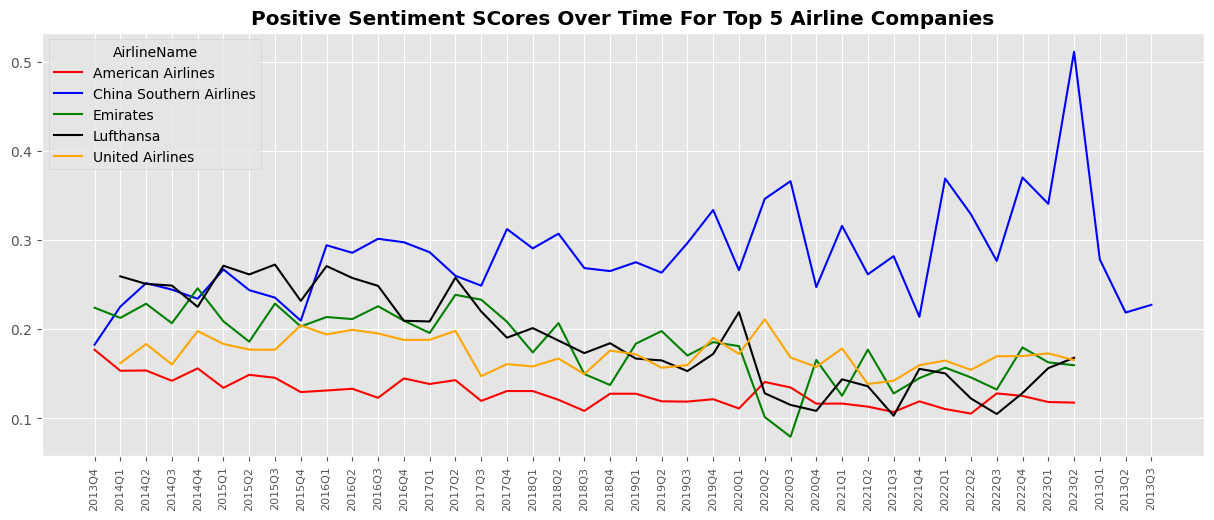

In [14]:
df_filtered=df.query('AirlineName in @best.index.get_level_values(0)')
g=df_filtered.groupby(['AirlineName',df_filtered['DatePub'].dt.to_period('Q')])['Positive Sentiment Scores'].mean()

plt.figure(figsize=(15,5.5))
sns.lineplot(x=[str(i[1]) for i in g.index],y=g.values,hue=g.index.get_level_values(0),palette=['Red','Blue','Green','Black','Orange'])
plt.title('Positive Sentiment SCores Over Time For Top 5 Airline Companies',fontweight='bold')
plt.xticks(rotation=90,size=8)
plt.show()

In [15]:
g=df.groupby(['AirlineName','CabinType'])\
[['EntertainmentRating','FoodRating','GroundServiceRating','SeatComfortRating','ServiceRating','ValueRating','WifiRating','OverallScore','Positive Sentiment Scores']].mean()

g.corr()['Positive Sentiment Scores'].sort_values(ascending=False)

#linear correlation coefficients between positive sentiment score and other scores

Positive Sentiment Scores    1.000000
OverallScore                 0.757046
ValueRating                  0.675355
FoodRating                   0.515879
ServiceRating                0.498161
SeatComfortRating            0.496422
GroundServiceRating          0.388780
EntertainmentRating          0.301095
WifiRating                   0.066655
Name: Positive Sentiment Scores, dtype: float64